# Create Monthly CESM ice flux files

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import glob
import datetime as dt

%matplotlib inline

In [3]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

Load data for year 2015:

In [5]:
ice = np.empty((12, 2400, 1632))
folder='/ocean/brogalla/GEOTRACES/data/'

for i in range(1,13):
    if i < 10:
        file='ice_flux_y2015m0'+str(i)+'.nc'
    else:
        file='ice_flux_y2015m'+str(i)+'.nc'
    ice_flux  = nc.Dataset(folder+file)
    dust_flux = np.array(ice_flux.variables['dust'])
    
    ice[i-1,:,:] = dust_flux 

Plus ice concentration in LIM2:

In [6]:
filei1  = 'ANHA12-EXH006_5d_icemod_y2015m01d05.nc'
filei2  = 'ANHA12-EXH006_5d_icemod_y2015m02d04.nc'
filei3  = 'ANHA12-EXH006_5d_icemod_y2015m03d01.nc'
filei4  = 'ANHA12-EXH006_5d_icemod_y2015m04d05.nc'
filei5  = 'ANHA12-EXH006_5d_icemod_y2015m05d05.nc'
filei6  = 'ANHA12-EXH006_5d_icemod_y2015m06d04.nc'
filei7  = 'ANHA12-EXH006_5d_icemod_y2015m07d04.nc'
filei8  = 'ANHA12-EXH006_5d_icemod_y2015m08d03.nc'
filei9  = 'ANHA12-EXH006_5d_icemod_y2015m09d02.nc'
filei10 = 'ANHA12-EXH006_5d_icemod_y2015m10d02.nc'
filei11 = 'ANHA12-EXH006_5d_icemod_y2015m11d01.nc'
filei12 = 'ANHA12-EXH006_5d_icemod_y2015m12d01.nc'

In [7]:
def load_variables(filename):
    folder  = '/data/brogalla/ANHA12/'
    a = nc.Dataset(folder+filename)
    
    # shape: (1, 2400, 1632)
    ice_prod = np.array(a.variables['iiceprod'][0])*3600*24/180 # ice production [m/kt] --> [m/day]
    ice_thic = np.array(a.variables['iicethic'][0])      # ice thickness [m]
    ice_temp = np.array(a.variables['iicetemp'][0])      # ice temperature [C]
    
    return ice_prod, ice_thic, ice_temp

In [43]:
ice_prod = np.empty((12, 2400, 1632))
ice_thic = np.empty((12, 2400, 1632))
ice_temp = np.empty((12, 2400, 1632))

filei=[filei1, filei2, filei3, filei4, filei5, filei6, \
       filei7, filei8, filei9, filei10, filei11, filei12]

for i in range(0,12):
    ice_prod[i,:,:], ice_thic[i,:,:], ice_temp[i,:,:] = load_variables(filei[i])

In [44]:
print(np.amax(ice_prod), np.amin(ice_prod))

0.24255667626857758 -0.5479736924171448


What do the ice production units mean? Units are: meters/kT. Product of the boltzmann constant (1.38e-23 J/K) and the temperature? More likely it's the time step.

In [64]:
def plot_field(n, vmin, vmax):
    fig, ax = plt.subplots(2,2,figsize=(16,12))

    proj1 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax[0,0])
    proj2 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax[0,1])
    proj3 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax[1,0])
    proj4 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax[1,1])

    x_land, y_land = proj2(lons, lats)
    proj1.contourf(x_land[::5,::5], y_land[::5,::5], land_mask[0,::5,::5], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
    proj2.contourf(x_land[::5,::5], y_land[::5,::5], land_mask[0,::5,::5], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
    proj3.contourf(x_land[::5,::5], y_land[::5,::5], land_mask[0,::5,::5], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
    proj4.contourf(x_land[::5,::5], y_land[::5,::5], land_mask[0,::5,::5], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    clevels = np.linspace(vmin, vmax, 20)
    CS1 = proj1.contourf(x_land, y_land, ice_thic[n,:,:], vmin=0.0, vmax=5.0, levels=20, cmap=cmocean.cm.ice)
    CS2 = proj2.contourf(x_land, y_land, ice_thic[n+1,:,:], vmin=0.0, vmax=5.0, levels=20, cmap=cmocean.cm.ice)
    CS3 = proj3.contourf(x_land, y_land, ice_prod[n,:,:], vmin=vmin, vmax=vmax, levels=clevels, cmap=cmocean.cm.balance_r) # cm/kt
    CS4 = proj4.contourf(x_land, y_land, ice_prod[n+1,:,:], vmin=vmin, vmax=vmax, levels=clevels, cmap=cmocean.cm.balance_r)

    ax[0,0].set_title('Month: '+str(n+1))
    ax[0,1].set_title('Month: '+str(n+2))

    cbaxes1 = fig.add_axes([0.48, 0.53, 0.04, 0.35]) 
    cbaxes2 = fig.add_axes([0.92, 0.53, 0.04, 0.35]) 
    cbaxes3 = fig.add_axes([0.48, 0.13, 0.04, 0.35]) 
    cbaxes4 = fig.add_axes([0.92, 0.13, 0.04, 0.35]) 
    cticks = np.linspace(vmin, vmax, 5)
    CB1 = plt.colorbar(CS1, ax=ax[0,0], cax=cbaxes1, ticks=np.arange(0,8,1))
    CB2 = plt.colorbar(CS2, ax=ax[0,1], cax=cbaxes2, ticks=np.arange(0,8,1))
    CB3 = plt.colorbar(CS3, ax=ax[1,0], cax=cbaxes3, ticks=cticks)
    CB4 = plt.colorbar(CS4, ax=ax[1,1], cax=cbaxes4, ticks=cticks)
    
    return

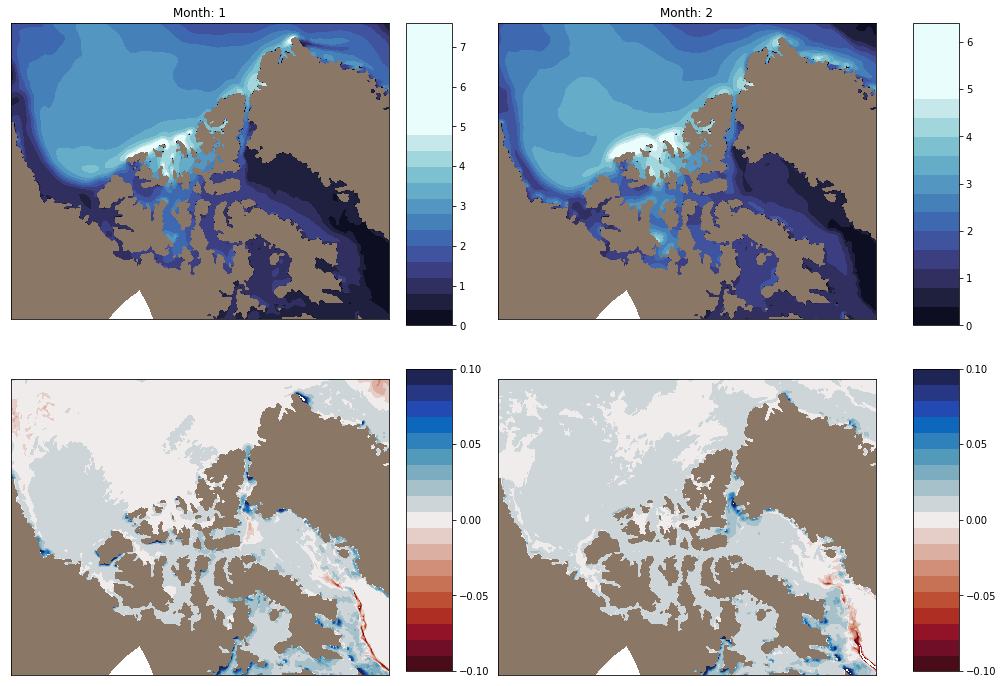

In [65]:
plot_field(0, -0.1, 0.1)

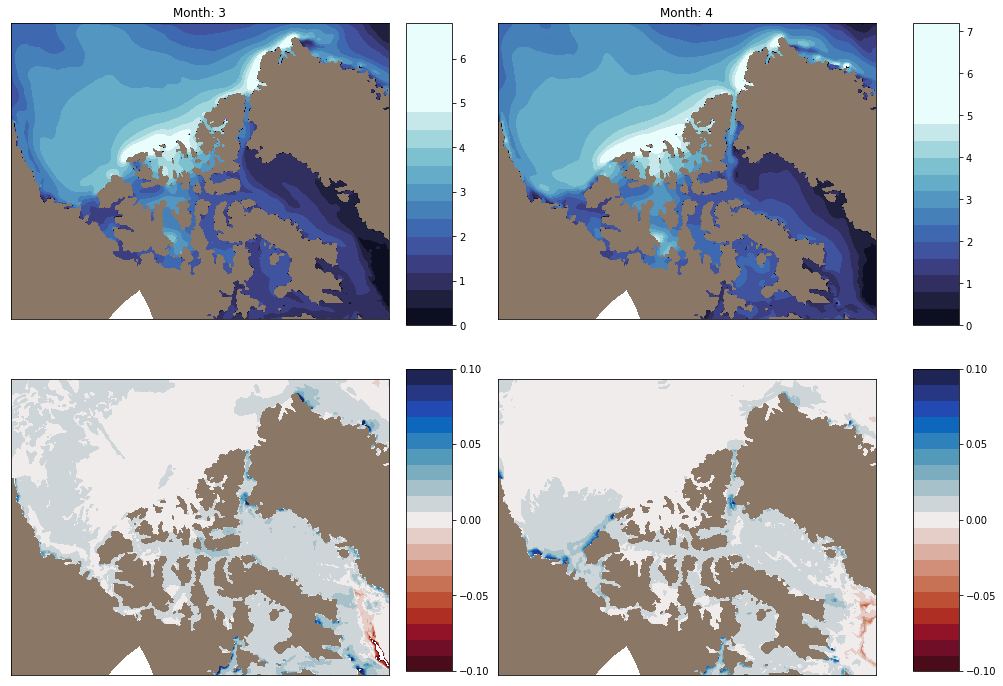

In [66]:
plot_field(2, -0.1, 0.1)

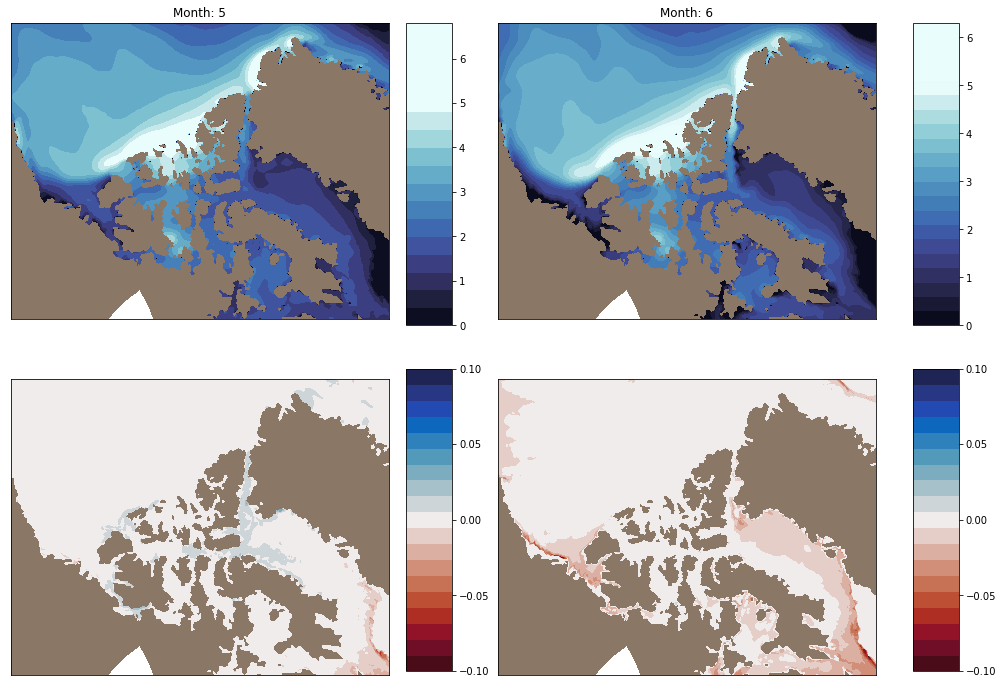

In [67]:
plot_field(4, -0.1, 0.1)

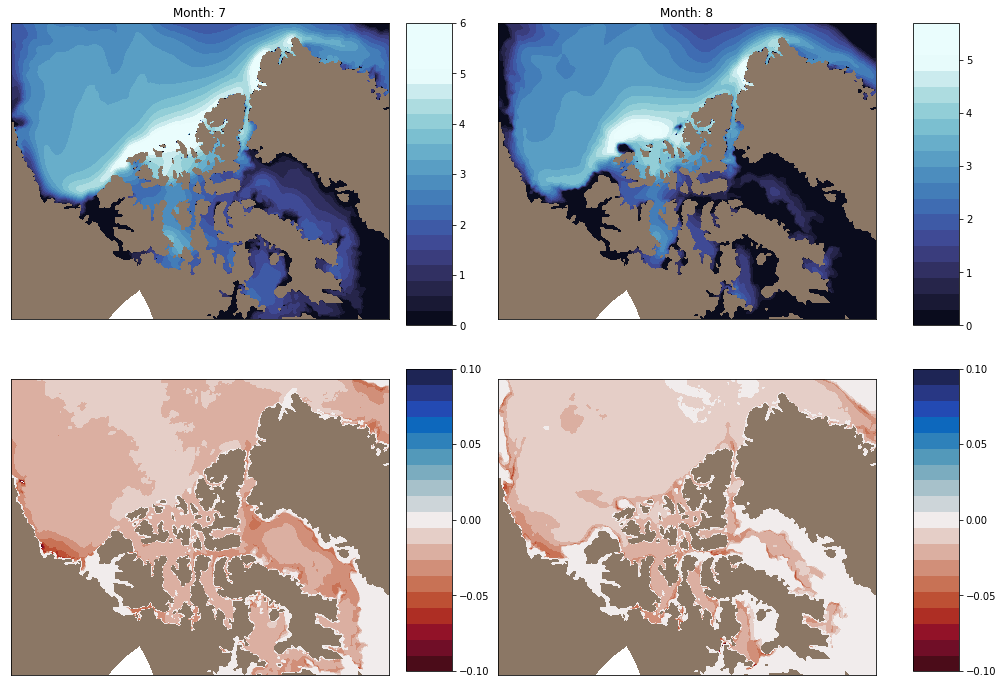

In [68]:
plot_field(6, -0.1, 0.1)

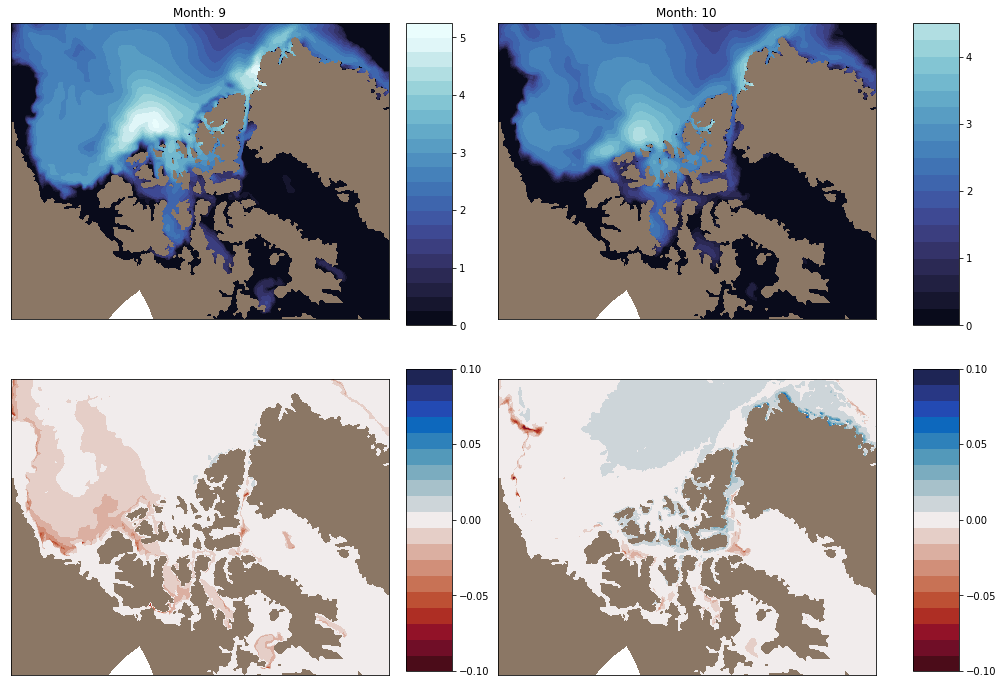

In [69]:
plot_field(8, -0.1, 0.1)

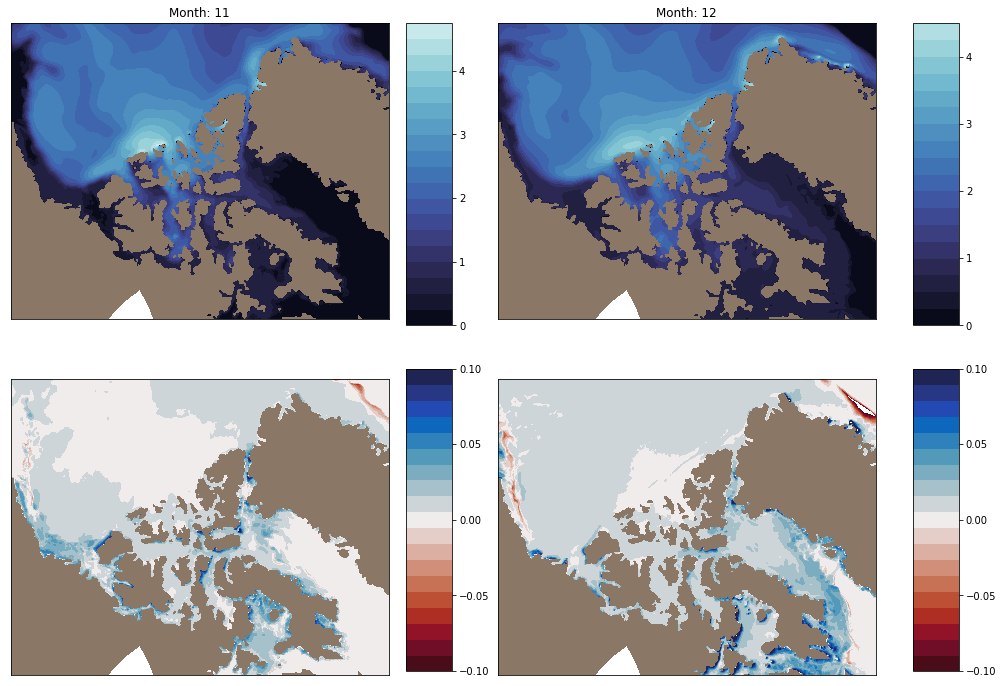

In [70]:
plot_field(10, -0.1, 0.1)

Annual cumulative sea-ice production:

In [8]:
def read_variable(filename):
    a = nc.Dataset(filename)
    
    # shape: (1, 2400, 1632)
    ice_prod = np.array(a.variables['iiceprod'][0])*3600*24*5/180 # ice production [m/kt] --> [m/5day]

    return ice_prod

In [82]:
ice_produced = np.zeros((2400,1632))

for filename in ice_files:
    ice_prod = read_variable(filename)
    ice_produced = ice_produced + ice_prod

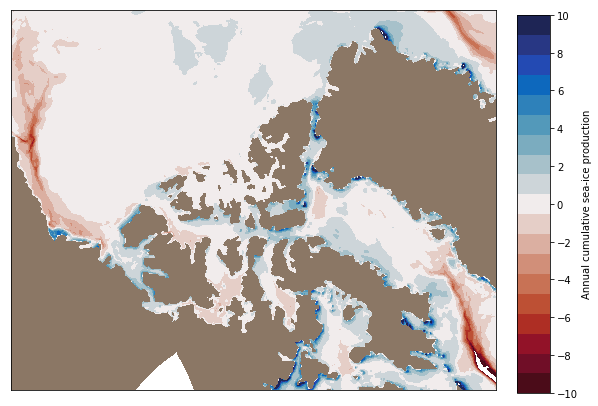

In [91]:
fig, ax = plt.subplots(1,1,figsize=(9,7))

proj1 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax)
x_land, y_land = proj1(lons, lats)
proj1.contourf(x_land[::5,::5], y_land[::5,::5], land_mask[0,::5,::5], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

clevels = np.linspace(-10, 10, 20)
CS1 = proj1.contourf(x_land, y_land, ice_produced, vmin=-10, vmax=10, levels=clevels, cmap=cmocean.cm.balance_r) 

cbaxes1 = fig.add_axes([0.92, 0.12, 0.05, 0.75])
cticks = np.linspace(-10, 10, 11)
CB1 = plt.colorbar(CS1, ax=ax, cax=cbaxes1, ticks=cticks, label='Annual cumulative sea-ice production')

Comparable to iwamoto et al. 2014:

In [9]:
years = ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
ice_produced = np.zeros((2400,1632))

months = ['09', '10', '11', '12', '01', '02', '03', '04', '05'] #winter months

for year in years:
    for month in months:
        ice_files = glob.glob('/data/brogalla/ANHA12/ANHA12-EXH006_5d_icemod_y20'+year+'m'+month+'*')

        for filename in ice_files:
            ice_prod = read_variable(filename)
            ice_produced = ice_produced + ice_prod

In [26]:
ave_ice_prod = ice_produced/len(years)
ave_ice_prod2 = ave_ice_prod
ave_ice_prod2[ave_ice_prod < 1.2] = np.nan

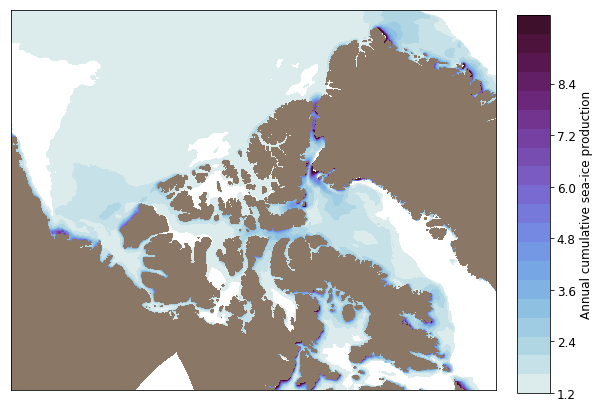

In [46]:
fig, ax = plt.subplots(1,1,figsize=(9,7))

proj1 = Basemap(projection='stere',lat_0 = 76.7, lon_0 = -94, resolution='i', width=3.8e6, height=2.98e6, ax=ax)
x_land, y_land = proj1(lons, lats)
proj1.contourf(x_land[:,:], y_land[:,:], land_mask[0,:,:], \
                   vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

clevels = np.linspace(1.2, 10, 21)
CS1 = proj1.contourf(x_land, y_land, ave_ice_prod2, vmin=1.2, vmax=10, levels=clevels, cmap=cmocean.cm.dense) 

cbaxes1 = fig.add_axes([0.92, 0.12, 0.05, 0.75])
cticks = [1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4]
CB1 = plt.colorbar(CS1, ax=ax, cax=cbaxes1, ticks=cticks)
CB1.ax.tick_params(labelsize=12)
CB1.set_label(label='Annual cumulative sea-ice production', size='large')

fig.savefig('/ocean/brogalla/GEOTRACES/figures/ice-prod-ANHA12.png', bbox_inches='tight', dpi=300)